# Data Processing - Analysis of tweets by reactions and ratings

## Import Required Packages

In [118]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import pandas as pd
import re
import string
from random import randint
import math as m

from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from collections import Counter

from sklearn.svm import SVC, LinearSVC
from sklearn import SVM
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

from sklearn.preprocessing import LabelEncoder, StandardScaler, OrdinalEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score, recall_score, precision_score,f1_score

ImportError: cannot import name 'SVM' from 'sklearn' (C:\Users\chaikatishar\Anaconda3\lib\site-packages\sklearn\__init__.py)

## Read Tweet Data from CSV

In [143]:
# Use pandas to ingest data from csv file
tweets = pd.read_csv('tweets_harvested_data_final.csv')

## Descriptive Statistics

In [144]:
tweets.describe()

,tweet_id,retweet_count,quote_count,reply_count,favorite_count
count,4.900000e+03,4900.000000,4900.000000,4900.000000,4900.000000
mean,1.342603e+18,1.442245,0.971020,2.351633,8.228367
std,6.174369e+16,4.061646,4.069008,5.335855,19.066773
min,1.240862e+18,0.000000,0.000000,0.000000,0.000000
25%,1.274015e+18,0.000000,0.000000,0.000000,2.000000
50%,1.368067e+18,1.000000,0.000000,1.000000,4.000000
75%,1.394375e+18,2.000000,1.000000,2.000000,9.000000
max,1.421714e+18,171.000000,126.000000,91.000000,596.000000


In [145]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4900 entries, 0 to 4899
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   tweet_id        4900 non-null   int64 
 1   created_at      4900 non-null   object
 2   text            4900 non-null   object
 3   retweet_count   4900 non-null   int64 
 4   quote_count     4900 non-null   int64 
 5   reply_count     4900 non-null   int64 
 6   favorite_count  4900 non-null   int64 
dtypes: int64(5), object(2)
memory usage: 268.1+ KB


## Sample Records
### HEAD - Display top 5 observations

In [146]:
tweets.head()

,tweet_id,created_at,text,retweet_count,quote_count,reply_count,favorite_count
0,1421713684791955460,Sun Aug 01 06:05:31 +0000 2021,https://t.co/DB8QOR5vBd\nECZ says Investigatio...,1,2,1,14
1,1421711016732266504,Sun Aug 01 05:54:55 +0000 2021,https://t.co/nrJuxItvkr\nChief Simamba castiga...,2,1,4,7
2,1421707047737991169,Sun Aug 01 05:39:08 +0000 2021,https://t.co/CJxF04D6jU\nI Survived the Corona...,1,0,0,4
3,1421704125067235329,Sun Aug 01 05:27:32 +0000 2021,https://t.co/EwsIfq7fUR\nZambia commits to sup...,0,0,2,6
4,1421702425434537984,Sun Aug 01 05:20:46 +0000 2021,https://t.co/r6XV81L8OG\nThe Verification Proc...,1,0,0,8


### TAIL - Display last 5 observations

In [147]:
tweets.tail()

,tweet_id,created_at,text,retweet_count,quote_count,reply_count,favorite_count
4895,1240868957877424129,Fri Mar 20 05:13:08 +0000 2020,https://t.co/2RSia7jdaT\nCholera more deadly t...,1,2,9,7
4896,1240868204588777477,Fri Mar 20 05:10:08 +0000 2020,https://t.co/EmqxNOXpQT\nFAZ Suspends League O...,0,0,0,1
4897,1240865962129326081,Fri Mar 20 05:01:14 +0000 2020,https://t.co/wyYqAPCXV8\nKanganja directs the ...,5,0,1,14
4898,1240862750848569344,Fri Mar 20 04:48:28 +0000 2020,https://t.co/T6h0xlmhbx\nLusaka Water advises ...,2,0,1,3
4899,1240861937505894400,Fri Mar 20 04:45:14 +0000 2020,https://t.co/4dnuUEDZBH\nUPND Justifies the be...,2,1,1,3


## Data Pre-processing

## Retweet Count Feature

### Analyse Feature Distribution and Identify Outliers

<Figure size 1152x360 with 0 Axes>

<AxesSubplot:xlabel='retweet_count', ylabel='Density'>

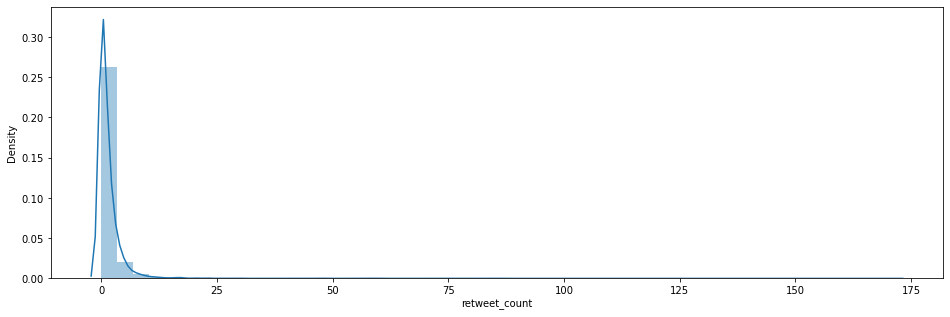

In [148]:
plt.figure(figsize=(16,5))
sns.distplot(tweets['retweet_count'])

In [149]:
#Identify outliers
#Calculate retweet quantiles to confirm outlier ranges

#add column for retweet quantiles, 
tweets['retweet_quantile'] = pd.cut(tweets['retweet_count'], bins=np.linspace(0, 171, 7),
                                     include_lowest = True)

#show quantile ranges
print(tweets['retweet_quantile'].value_counts())

(-0.001, 28.5]    4888
(28.5, 57.0]         8
(57.0, 85.5]         2
(142.5, 171.0]       1
(85.5, 114.0]        1
(114.0, 142.5]       0
Name: retweet_quantile, dtype: int64


In [150]:
# value counts confirm 99.7% of observations are between 0 and 29, other ranges 
# will be treated as outliers and will be updated with the average figure

# get average
retweet_mean = tweets['retweet_count'].mean() # = 1.4422448979591838

#round off
retweet_mean = m.ceil(retweet_mean) # = 2

#use mask to update outliers, above 28.5

tweets.loc[tweets['retweet_count'] > 28.5, "retweet_count"] = retweet_mean

### confirm removal of outliers

In [151]:
#check max value
print(tweets['retweet_count'].max())

#max value 28 confirms outliers removed

28


### recompute quantile to reflect removal of outliers

In [152]:
#compute and replace quantile field, use 4 bins
tweets['retweet_quantile'] = pd.cut(tweets['retweet_count'], bins=np.linspace(0, 28, 5),
                                     include_lowest = True)

print(tweets['retweet_quantile'].value_counts())

(-0.001, 7.0]    4788
(7.0, 14.0]        86
(14.0, 21.0]       20
(21.0, 28.0]        6
Name: retweet_quantile, dtype: int64


In [153]:
#recompute quantile with custom bin edges
# 0 - 1 Low
# 1 - 3 Average
# 3 - 6 High
# 6 - 28 Very High

tweets['retweet_quantile'] = pd.cut(tweets['retweet_count'], bins=[0,1,3,6,28],
                                    labels = ['A-Low','B-Average','C-High','D-Very High'],include_lowest = True)

print(tweets['retweet_quantile'].value_counts())

A-Low          3524
B-Average       883
C-High          342
D-Very High     151
Name: retweet_quantile, dtype: int64


### Label Encode Feature

In [154]:
#use label encoder to encode tweet labels
retweet_label = LabelEncoder()

tweets['retweet_label'] = retweet_label.fit_transform(tweets['retweet_quantile'])

#show values counts
tweets['retweet_label'].value_counts()

0    3524
1     883
2     342
3     151
Name: retweet_label, dtype: int64

## Quote Count Feature

### Analyse Feature Distribution and Identify Outliers

<Figure size 1152x360 with 0 Axes>

<AxesSubplot:xlabel='quote_count', ylabel='Density'>

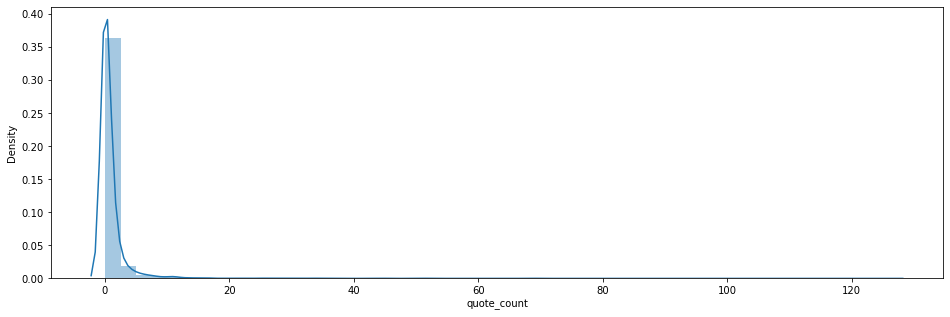

In [155]:
plt.figure(figsize=(16,5))
sns.distplot(tweets['quote_count'])

In [156]:
#Identify outliers
#Calculate quote quantiles to confirm outlier ranges

#add column for retweet quantiles, 
tweets['quote_quantile'] = pd.cut(tweets['quote_count'], bins=np.linspace(0, 126, 7),
                                     include_lowest = True)

#show quantile ranges
print(tweets['quote_quantile'].value_counts())

(-0.001, 21.0]    4871
(21.0, 42.0]        19
(42.0, 63.0]         6
(63.0, 84.0]         2
(105.0, 126.0]       1
(84.0, 105.0]        1
Name: quote_quantile, dtype: int64


In [157]:
# value counts confirm 99.4% of observations are between 0 and 21, other ranges 
# will be treated as outliers and will be updated with the average figure

# get average
quote_mean = tweets['quote_count'].mean() # = 0.9710204081632653
print(quote_mean)

#round off
quote_mean = m.ceil(retweet_mean) # = 2
print(quote_mean)

#use mask to update outliers, above 21

tweets.loc[tweets['quote_count'] > 21, "quote_count"] = quote_mean

0.9710204081632653
2


### confirm removal of outliers

In [158]:
#check max value
print(tweets['quote_count'].max())

#max value 20 confirms outliers removed

20


### recompute quantile to reflect removal of outliers

In [159]:
#compute and replace quantile field, use 4 bins
tweets['quote_quantile'] = pd.cut(tweets['quote_count'], bins=np.linspace(0, 20, 5),
                                     include_lowest = True)

print(tweets['quote_quantile'].value_counts())

(-0.001, 5.0]    4758
(5.0, 10.0]        97
(10.0, 15.0]       35
(15.0, 20.0]       10
Name: quote_quantile, dtype: int64


In [160]:
#recompute quantile with custom bin edges
# 0 - 1 Low
# 1 - 2 Average
# 2 - 5 High
# 5 - 20 Very High

tweets['quote_quantile'] = pd.cut(tweets['quote_count'], bins=[0,1,2,5,20],
                                    labels = ['A-Low','B-Average','C-High','D-Very High'],include_lowest = True)

print(tweets['quote_quantile'].value_counts())

A-Low          4214
B-Average       309
C-High          235
D-Very High     142
Name: quote_quantile, dtype: int64


### Label Encode Feature

In [161]:
#use label encoder to encode tweet labels
quote_label = LabelEncoder()

tweets['quote_label'] = quote_label.fit_transform(tweets['quote_quantile'])

#show values counts
tweets['quote_label'].value_counts()

0    4214
1     309
2     235
3     142
Name: quote_label, dtype: int64

## Reply Count Feature

### Analyse Feature Distribution and Identify Outliers

<Figure size 1152x360 with 0 Axes>

<AxesSubplot:xlabel='reply_count', ylabel='Density'>

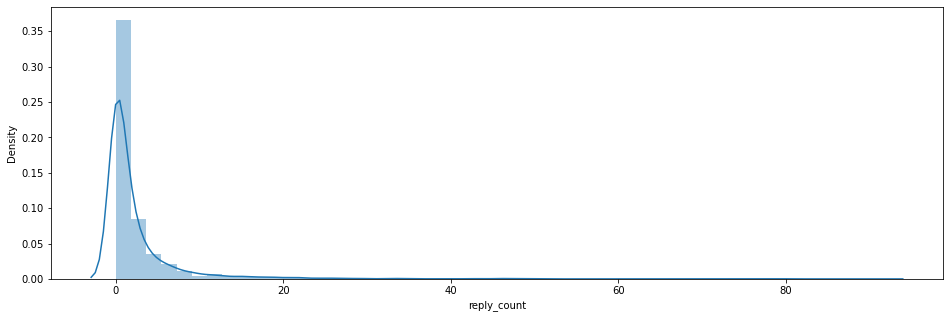

In [162]:
plt.figure(figsize=(16,5))
sns.distplot(tweets['reply_count'])

In [163]:
#Identify outliers
#Calculate reply quantiles to confirm outlier ranges

#add column for retweet quantiles, 
tweets['reply_quantile'] = pd.cut(tweets['reply_count'], bins=np.linspace(0, 91, 7),
                                     include_lowest = True)

#show quantile ranges
print(tweets['reply_quantile'].value_counts())

(-0.001, 15.167]    4761
(15.167, 30.333]     108
(30.333, 45.5]        18
(45.5, 60.667]         9
(75.833, 91.0]         3
(60.667, 75.833]       1
Name: reply_quantile, dtype: int64


In [164]:
# value counts confirm 99.3% of observations are between 0 and 31, other ranges 
# will be treated as outliers and will be updated with the average figure

# get average
reply_mean = tweets['reply_count'].mean() # = 2.3516326530612246
print(reply_mean)

#round off
reply_mean = m.ceil(reply_mean) # = 3
print(reply_mean)

#use mask to update outliers, above 31
tweets.loc[tweets['reply_count'] > 31, "reply_count"] = reply_mean

2.3516326530612246
3


### confirm removal of outliers

In [165]:
#check max value
print(tweets['reply_count'].max())

#max value 20 confirms outliers removed

30


### recompute quantile to reflect removal of outliers

In [166]:
#compute and replace quantile field, use 4 bins
tweets['reply_quantile'] = pd.cut(tweets['reply_count'], bins=np.linspace(0, 30, 5),
                                     include_lowest = True)

print(tweets['reply_quantile'].value_counts())

(-0.001, 7.5]    4547
(7.5, 15.0]       245
(15.0, 22.5]       79
(22.5, 30.0]       29
Name: reply_quantile, dtype: int64


In [167]:
#recompute quantile with custom bin edges
# 0 - 1 Low
# 1 - 2 Average
# 2 - 5 High
# 5 - 30 Very High

tweets['reply_quantile'] = pd.cut(tweets['reply_count'], bins=[0,1,2,5,30],
                                    labels = ['A-Low','B-Average','C-High','D-Very High'],include_lowest = True)

print(tweets['reply_quantile'].value_counts())

A-Low          3263
C-High          626
D-Very High     540
B-Average       471
Name: reply_quantile, dtype: int64


### Label Encode Feature

In [168]:
#use label encoder to encode tweet labels
reply_label = LabelEncoder()

tweets['reply_label'] = quote_label.fit_transform(tweets['reply_quantile'])

#show values counts
tweets['reply_label'].value_counts()

0    3263
2     626
3     540
1     471
Name: reply_label, dtype: int64

## Favorite Count Feature

### Analyse Feature Distribution and Identify Outliers

<Figure size 1152x360 with 0 Axes>

<AxesSubplot:xlabel='favorite_count', ylabel='Density'>

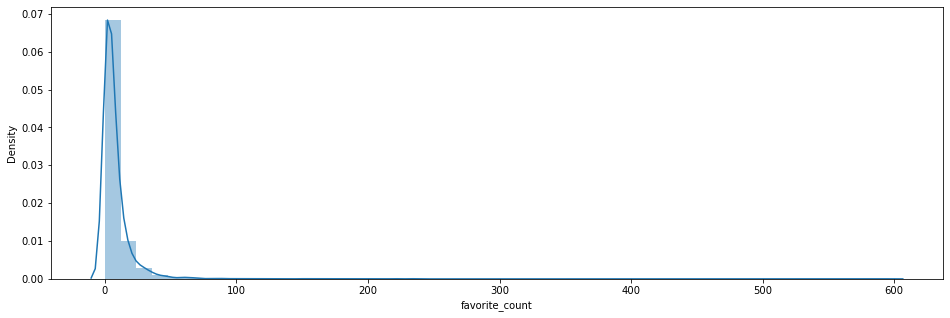

In [169]:
plt.figure(figsize=(16,5))
sns.distplot(tweets['favorite_count'])

In [170]:
#Identify outliers
#Calculate reply quantiles to confirm outlier ranges

#add column for retweet quantiles, 
tweets['favorite_quantile'] = pd.cut(tweets['favorite_count'], bins=np.linspace(0, 596, 7),
                                     include_lowest = True)

#show quantile ranges
print(tweets['favorite_quantile'].value_counts())

(-0.001, 99.333]      4876
(99.333, 198.667]       16
(198.667, 298.0]         5
(496.667, 596.0]         2
(298.0, 397.333]         1
(397.333, 496.667]       0
Name: favorite_quantile, dtype: int64


In [171]:
# value counts confirm 99.5% of observations are between 0 and 100, other ranges 
# will be treated as outliers and will be updated with the average figure

# get average
favorite_mean = tweets['favorite_count'].mean() # = 8.228367346938775
print(favorite_mean)

#round off
favorite_mean = m.ceil(favorite_mean) # = 9
print(favorite_mean)

#use mask to update outliers, above 100
tweets.loc[tweets['favorite_count'] > 100, "favorite_count"] = favorite_mean

8.228367346938775
9


### confirm removal of outliers

In [172]:
#check max value
print(tweets['favorite_count'].max())

#max value 100 confirms outliers removed

100


### recompute quantile to reflect removal of outliers

In [173]:
#compute and replace quantile field, use 4 bins
tweets['favorite_quantile'] = pd.cut(tweets['favorite_count'], bins=np.linspace(0, 100, 5),
                                     include_lowest = True)

print(tweets['favorite_quantile'].value_counts())

(-0.001, 25.0]    4647
(25.0, 50.0]       208
(50.0, 75.0]        35
(75.0, 100.0]       10
Name: favorite_quantile, dtype: int64


In [174]:
#recompute quantile with custom bin edges
# 0 - 5 Low
# 5 - 8 Average
# 8 - 25 High
# 25 - 100 Very High

tweets['favorite_quantile'] = pd.cut(tweets['favorite_count'], bins=[0,5,8,25,100],
                                    labels = ['A-Low','B-Average','C-High','D-Very High'],include_lowest = True)

print(tweets['favorite_quantile'].value_counts())

A-Low          2924
C-High         1037
B-Average       686
D-Very High     253
Name: favorite_quantile, dtype: int64


### Label Encode Feature

In [175]:
#use label encoder to encode tweet labels
favorite_label = LabelEncoder()

tweets['favorite_label'] = quote_label.fit_transform(tweets['favorite_quantile'])

#show values counts
tweets['favorite_label'].value_counts()

0    2924
2    1037
1     686
3     253
Name: favorite_label, dtype: int64

In [176]:
tweets.head()

,tweet_id,created_at,text,retweet_count,quote_count,reply_count,favorite_count,retweet_quantile,retweet_label,quote_quantile,quote_label,reply_quantile,reply_label,favorite_quantile,favorite_label
0,1421713684791955460,Sun Aug 01 06:05:31 +0000 2021,https://t.co/DB8QOR5vBd\nECZ says Investigatio...,1,2,1,14,A-Low,0,B-Average,1,A-Low,0,C-High,2
1,1421711016732266504,Sun Aug 01 05:54:55 +0000 2021,https://t.co/nrJuxItvkr\nChief Simamba castiga...,2,1,4,7,B-Average,1,A-Low,0,C-High,2,B-Average,1
2,1421707047737991169,Sun Aug 01 05:39:08 +0000 2021,https://t.co/CJxF04D6jU\nI Survived the Corona...,1,0,0,4,A-Low,0,A-Low,0,A-Low,0,A-Low,0
3,1421704125067235329,Sun Aug 01 05:27:32 +0000 2021,https://t.co/EwsIfq7fUR\nZambia commits to sup...,0,0,2,6,A-Low,0,A-Low,0,B-Average,1,B-Average,1
4,1421702425434537984,Sun Aug 01 05:20:46 +0000 2021,https://t.co/r6XV81L8OG\nThe Verification Proc...,1,0,0,8,A-Low,0,A-Low,0,A-Low,0,B-Average,1


## Prepare encoded labels for Combined Feature Ranking

In [181]:
#since labels are zero based (0,1,2,3),add 1 to each label to transform range to (1,2,3,4) to allow for easy calculation
# of rankings
tweets['retweet_label'] = tweets['retweet_label'] + 1

tweets['quote_label'] = tweets['quote_label'] + 1

tweets['reply_label'] = tweets['reply_label'] + 1

tweets['favorite_label'] = tweets['favorite_label'] + 1

### Value Counts showing features transformed from 0-1 to 1-4

In [182]:
tweets['retweet_label'].value_counts()

1    3524
2     883
3     342
4     151
Name: retweet_label, dtype: int64

In [183]:
tweets['quote_label'].value_counts()

1    4214
2     309
3     235
4     142
Name: quote_label, dtype: int64

In [184]:
tweets['reply_label'].value_counts()

1    3263
3     626
4     540
2     471
Name: reply_label, dtype: int64

In [185]:
tweets['favorite_label'].value_counts()

1    2924
3    1037
2     686
4     253
Name: favorite_label, dtype: int64

## Combine labels for Tweet ranking feature

In [209]:
## add all features and calculate average

tweets['importance'] = round(((tweets['retweet_label'] + tweets['quote_label'] + tweets['reply_label'] + tweets['favorite_label'])/4),0)

In [210]:
tweets['importance'].value_counts()

1.0    2856
2.0    1593
3.0     317
4.0     134
Name: importance, dtype: int64

In [238]:
## add all features and calculate average_rounded

tweets['importance_weighted'] = round((((tweets['retweet_label']*2) + (tweets['quote_label']*2) + (tweets['reply_label']*4) + (tweets['favorite_label']*6))/14))

In [240]:
tweets['importance_weighted'].value_counts()

1.0    2947
2.0    1204
3.0     621
4.0     128
Name: importance_weighted, dtype: int64

In [243]:
## add all features and calculate average_

tweets['importance_weighted_avg'] = (((tweets['retweet_label']*2) + (tweets['quote_label']*2) + 
                                      (tweets['reply_label']*4) + (tweets['favorite_label']*6))/14)

tweets['importance_weighted_avg'] = tweets['importance_weighted_avg'].apply(lambda x: m.ceil(x))

In [244]:
tweets['importance_weighted_avg'].value_counts()

1    2177
2    1591
3     804
4     328
Name: importance_weighted_avg, dtype: int64

## Drop columns not required by estimators

In [231]:
tweets = tweets.drop(columns=['created_at','text','retweet_quantile','quote_quantile','reply_quantile', 'favorite_quantile','importance_ceil','importance','tweet_id' ])

In [247]:
tweets = tweets.drop(columns=['importance_weighted'])

<AxesSubplot:xlabel='importance_weighted_avg', ylabel='count'>

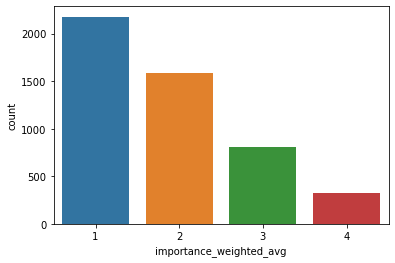

In [250]:
sns.countplot(tweets['importance_weighted_avg'])

In [248]:
tweets.head()

,retweet_count,quote_count,reply_count,favorite_count,retweet_label,quote_label,reply_label,favorite_label,importance_weighted_avg
0,1,2,1,14,1,2,1,3,2
1,2,1,4,7,2,1,3,2,3
2,1,0,0,4,1,1,1,1,1
3,0,0,2,6,1,1,2,2,2
4,1,0,0,8,1,1,1,2,2


## Seperate the dataset as Input Features and Target Feature

In [249]:
# Input = X, Target = y

X = tweets.drop(columns=['importance_weighted_avg'])
y = tweets['importance_weighted_avg']

## Split data - Training and Testing

In [251]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

## Linear Support Vector Classification

In [252]:
# Performing CV to tune parameters for best SVM fit
sv = LinearSVC()
sv.fit(X_train, y_train)

LinearSVC()

In [253]:
sv_pred = sv.predict(X_test)

In [260]:
target_names = ['Low','Average','High','Very High']

In [261]:
print(classification_report(y_test, sv_pred, target_names= target_names))

              precision    recall  f1-score   support

         Low       1.00      1.00      1.00       434
     Average       0.95      0.98      0.97       325
        High       0.87      0.85      0.86       158
   Very High       0.85      0.79      0.82        63

    accuracy                           0.96       980
   macro avg       0.92      0.91      0.91       980
weighted avg       0.95      0.96      0.95       980



<AxesSubplot:>

Text(33.0, 0.5, 'Actual')

Text(0.5, 15.0, 'Predicted')

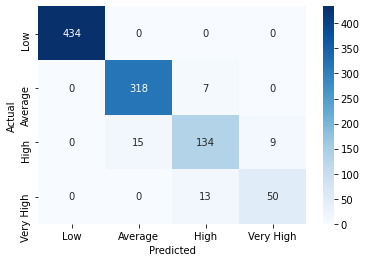

In [265]:
conf_mat = confusion_matrix(y_test, sv_pred)
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=target_names, yticklabels=target_names, cmap='Blues')
plt.ylabel('Actual')
plt.xlabel('Predicted')

## KNearest Neighbors Classifier

In [267]:
# KNeigbor classifier
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=3)

In [268]:
n_pred = neigh.predict(X_test)

In [269]:
target_names = ['Low','Average','High','Very High']

In [270]:
print(classification_report(y_test, n_pred, target_names= target_names))

              precision    recall  f1-score   support

         Low       1.00      1.00      1.00       434
     Average       0.99      1.00      1.00       325
        High       0.94      0.93      0.93       158
   Very High       0.86      0.86      0.86        63

    accuracy                           0.98       980
   macro avg       0.95      0.95      0.95       980
weighted avg       0.98      0.98      0.98       980



<AxesSubplot:>

Text(33.0, 0.5, 'Actual')

Text(0.5, 15.0, 'Predicted')

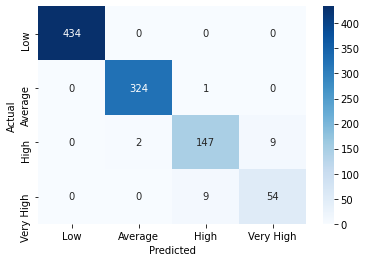

In [271]:
conf_mat_neigh = confusion_matrix(y_test, n_pred)
sns.heatmap(conf_mat_neigh, annot=True, fmt='d',
            xticklabels=target_names, yticklabels=target_names, cmap='Blues')
plt.ylabel('Actual')
plt.xlabel('Predicted')